model library install
```bash
pip install git+https://github.com/abcd-EGH/srnn-ae.git
```

In [93]:
!pip show srnn-ae

Name: srnn-ae
Version: 0.1.1
Summary: Sparsely connections RNN + AutoEncoder Model for Anomaly Detection in Time Series
Home-page: https://github.com/abcd-EGH/srnn-ae
Author: Jihwan Lee (abcd-EGH)
Author-email: wlghks7790@gmail.com
License: MIT
Location: C:\Users\Jihwan\anaconda3\envs\ml_env\Lib\site-packages
Requires: numpy, torch
Required-by: 


In [3]:
from srnn_ae import SLSTMAutoEncoder, set_random_seed
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score, cohen_kappa_score
import matplotlib.pyplot as plt

In [4]:
# 데이터 로드 및 전처리 함수
def ReadNABDataset(_file_name, _normalize=True):
    with open('./NAB/labels/combined_windows.json') as data_file:
        json_label = json.load(data_file)
    
    # 데이터 디렉토리를 기준으로 상대 경로 계산
    relative_path = os.path.relpath(_file_name, './NAB/data')
    relative_path = relative_path.replace(os.sep, '/')  # 경로 구분자를 '/'로 통일
    
    print(f"Processing file: {relative_path}")  # 현재 처리 중인 파일명 출력
    
    list_windows = json_label.get(relative_path)
    
    if list_windows is None:
        print(f"Warning: No anomaly windows found for {relative_path}. All data labeled as normal.")
        abnormal = pd.read_csv(_file_name, header=0, index_col=0)
        abnormal['label'] = 1
    else:
        abnormal = pd.read_csv(_file_name, header=0, index_col=0)
        abnormal['label'] = 1
        for window in list_windows:
            start = window[0]
            end = window[1]
            abnormal.loc[start:end, 'label'] = -1

    abnormal_data = abnormal['value'].values
    abnormal_label = abnormal['label'].values

    abnormal_data = np.expand_dims(abnormal_data, axis=1)
    abnormal_label = np.expand_dims(abnormal_label, axis=1)

    if _normalize:
        scaler = MinMaxScaler(feature_range=(0, 1))
        abnormal_data = scaler.fit_transform(abnormal_data)

    # Normal = 1, Abnormal = -1
    return abnormal_data, abnormal_label 

def prepare_data(file_name, window_size=288, partition=True, k_partition=10):
    data, labels = ReadNABDataset(file_name)
    
    # 정상 데이터만 선택
    normal_data = data[labels.flatten() == 1]
    
    # 윈도우 분할
    windows = [normal_data[i:i+window_size] for i in range(len(normal_data) - window_size)]
    
    # 학습용과 검증용으로 분할 (80% 학습, 20% 검증)
    train_data, val_data = train_test_split(windows, test_size=0.2, shuffle=False)
    
    return np.array(train_data), np.array(val_data)

def prepare_test_data(file_name, window_size=288):
    data, labels = ReadNABDataset(file_name)
    # 윈도우 분할
    windows = [data[i:i+window_size] for i in range(len(data) - window_size)]
    labels_window = [labels[i+window_size] for i in range(len(data) - window_size)]
    windows = np.array(windows)  # Shape: (num_windows, window_size, 1) 예상
    labels_window = np.array(labels_window)  # Shape: (num_windows, 1) 또는 (num_windows,)
    
    # 윈도우에 채널 차원이 없는 경우 추가
    if len(windows.shape) == 2:
        windows = windows[:, :, np.newaxis]  # Shape: (num_windows, window_size, 1)
    
    # 레이블 차원 맞추기 (필요시)
    if len(labels_window.shape) == 1:
        labels_window = labels_window[:, np.newaxis]  # Shape: (num_windows, 1)
    
    return windows, labels_window

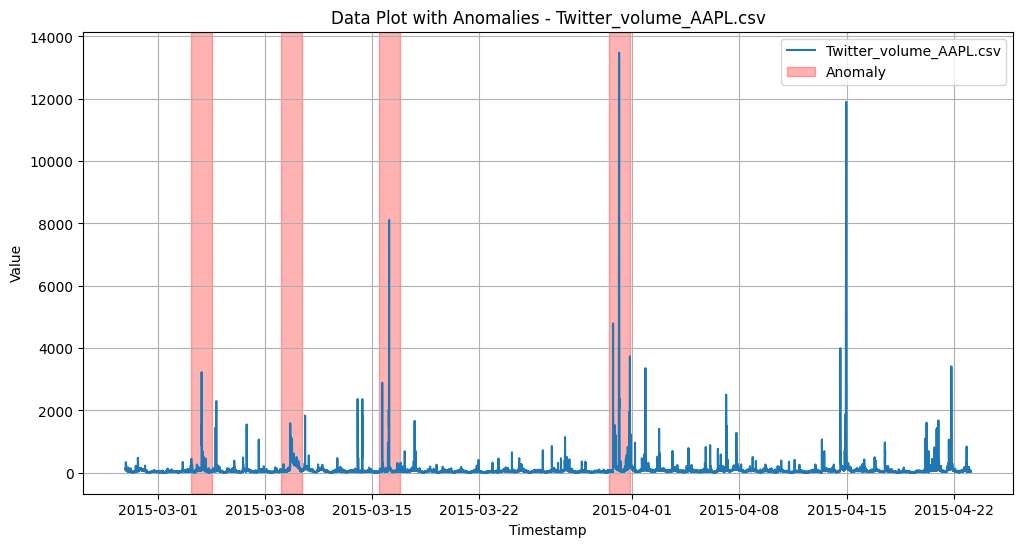

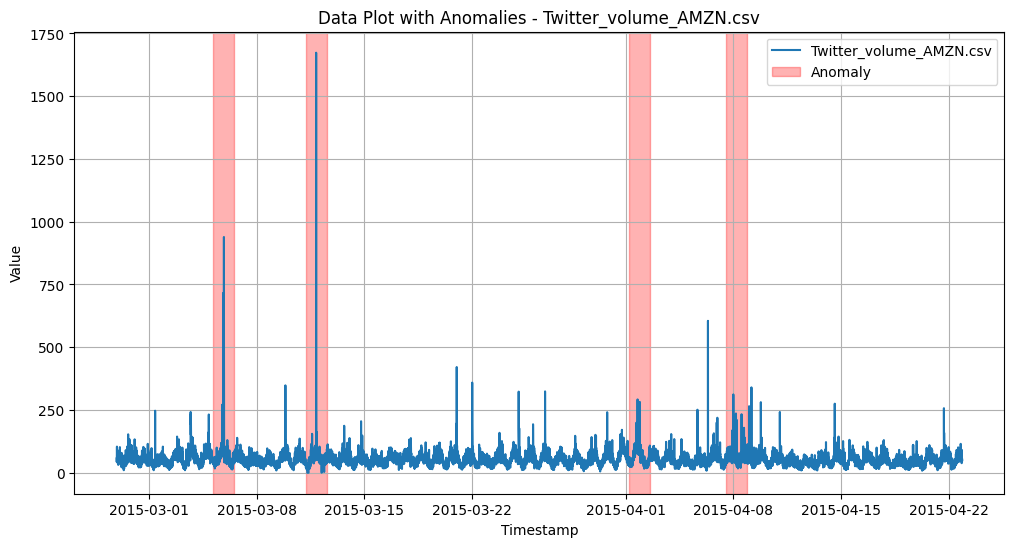

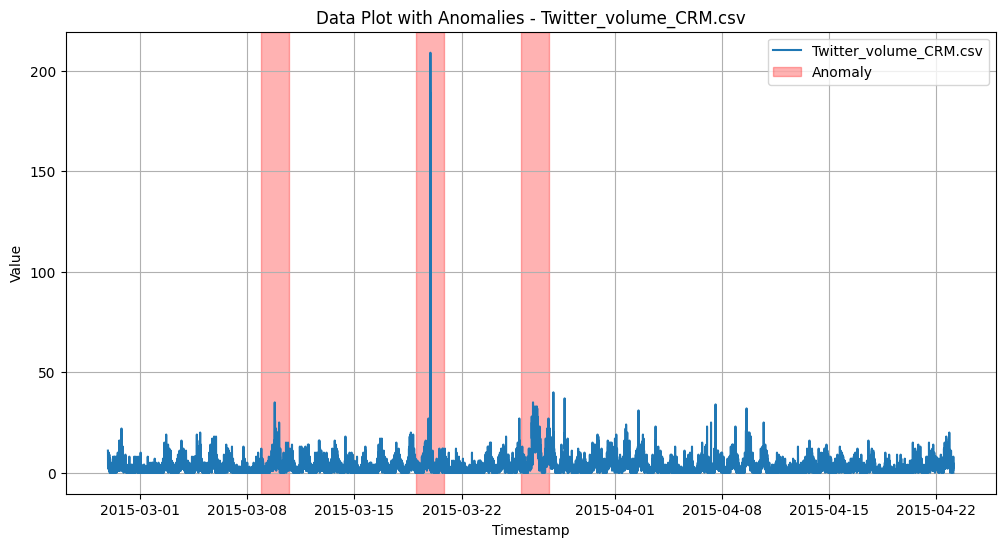

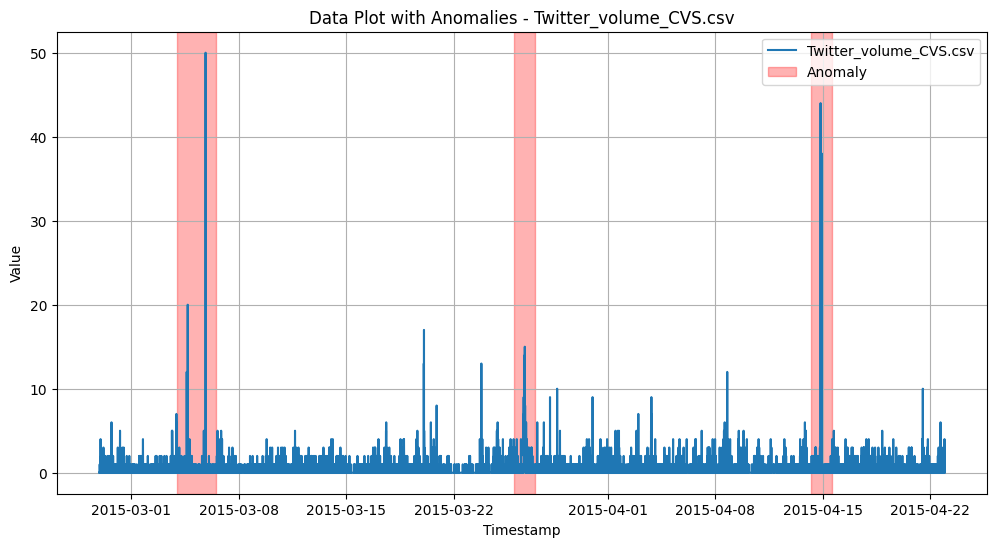

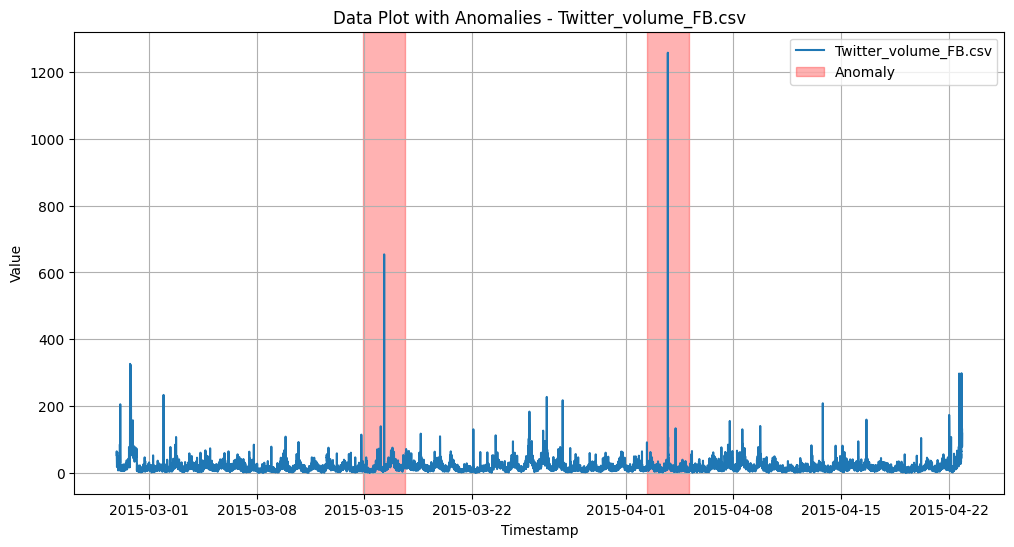

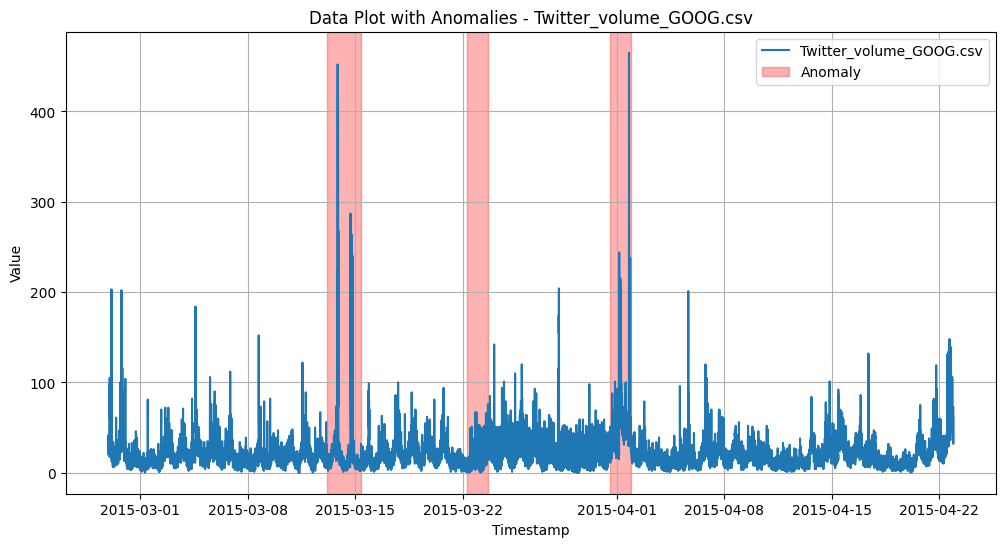

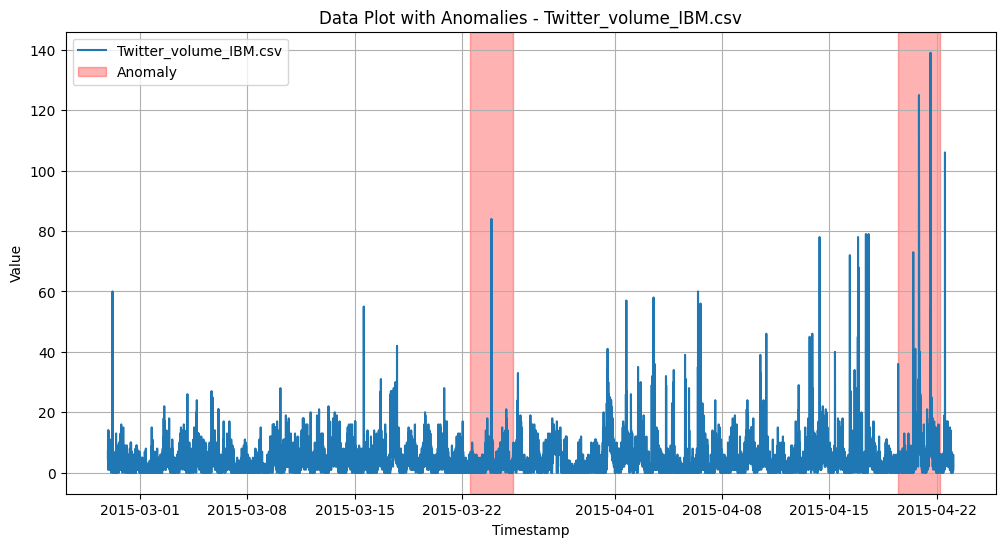

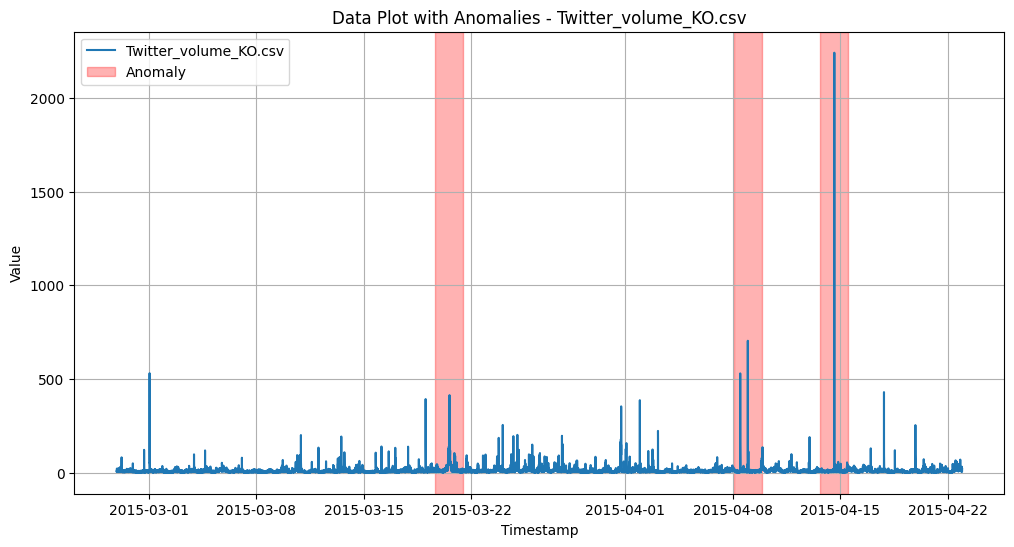

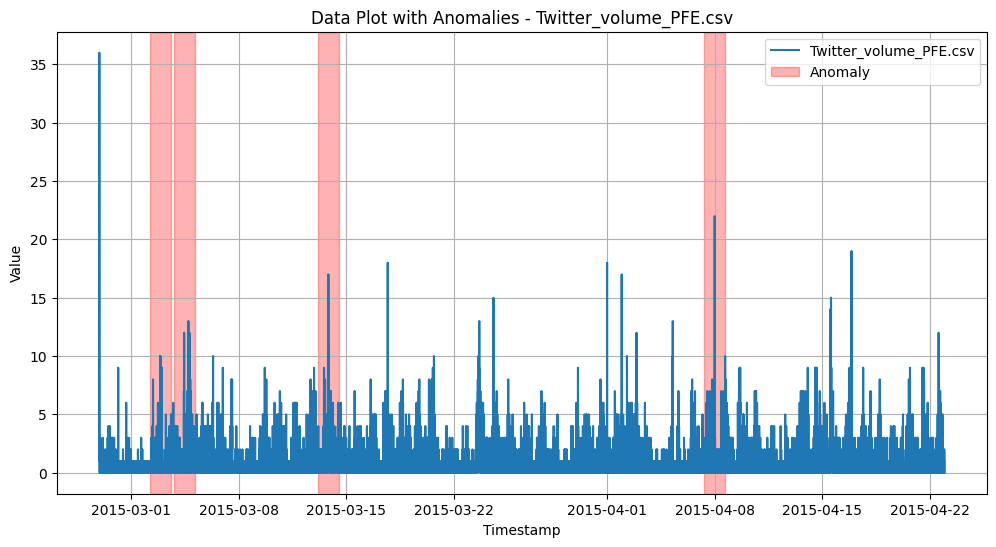

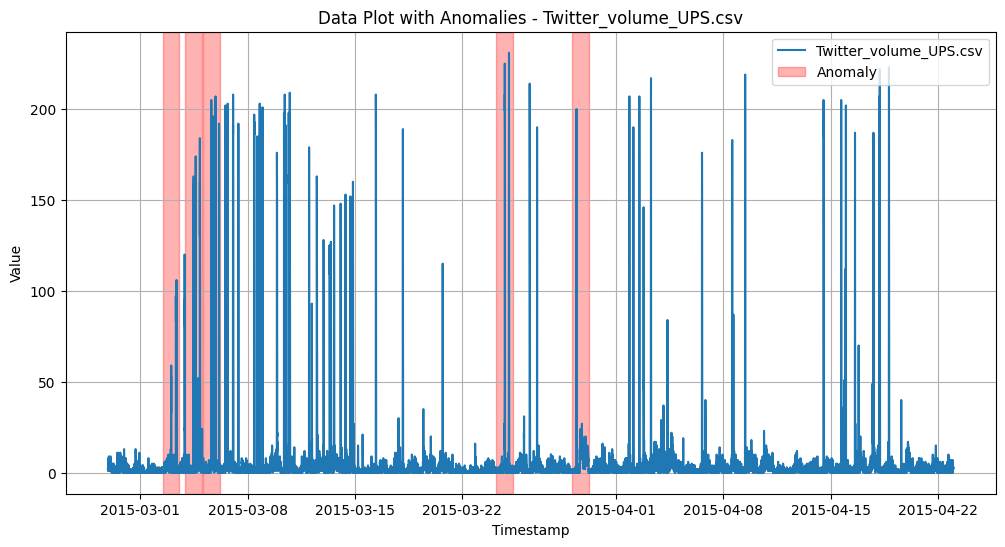

In [19]:
# 학습 데이터 디렉토리 설정
train_data_dir = './NAB/data/realTweets'

# 이상치 라벨 json 파일 경로 설정
anomaly_label_dir = './NAB/labels/combined_windows.json'

# 디렉토리 내의 모든 CSV 파일 불러오기
train_files = [f for f in os.listdir(train_data_dir) if f.endswith('.csv')]

# 이상치 라벨 JSON 파일 로드
with open(anomaly_label_dir, 'r') as f:
    anomaly_labels = json.load(f)

max_plot_num = 10  # 최대 몇 개 데이터까지 plot을 만들지
if len(train_files) > max_plot_num:
    train_files = train_files[:max_plot_num]

# 각 파일에 대해 데이터 로드 및 시각화
for train_file in train_files:
    train_data_file = os.path.join(train_data_dir, train_file)
    df_train = pd.read_csv(train_data_file)

    # 타임스탬프를 datetime 형식으로 변환
    df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
    df_train.set_index('timestamp', inplace=True)

    # 해당 파일의 이상치 라벨 가져오기
    # anomaly_labels의 키와 현재 파일 이름을 정확히 매칭
    # 파일의 상위 디렉토리 이름을 포함하여 상대 경로 생성
    dataset_name = os.path.basename(train_data_dir)  # 'realAWSCloudwatch'
    relative_path = f'{dataset_name}/{train_file}'

    anomaly_windows = anomaly_labels.get(relative_path, [])

    # 학습 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(df_train.index, df_train['value'], label=train_file)

    # 이상치 구간에 대해 영역 표시
    for idx, window in enumerate(anomaly_windows):
        start_time = pd.to_datetime(window[0])
        end_time = pd.to_datetime(window[1])
        plt.axvspan(start_time, end_time, color='red', alpha=0.3, label='Anomaly' if idx == 0 else "")

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Data Plot with Anomalies - {train_file}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [96]:
random_seed = 777

set_random_seed(random_seed)

# 하이퍼파라미터 설정
N = 3  # 앙상블 모델 수, 10 or 40
input_size = 1  # 단일 시계열
hidden_size = 8
output_size = 1
num_layers = 2
limit_skip_steps = 3 # L
learning_rate = 1e-3
l1_lambda = 0.005
batch_size = 1024
window_size = 288  # 시퀀스 길이 (1일 = 288 타임스텝 assuming 5분 간격)
num_epochs = 20

print("Hyperparameter Setting Complete")

# 데이터 준비
file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
train_data, val_data = prepare_data(file_name, window_size=window_size)

# 텐서 변환 (unsqueeze 제거)
train_tensor = torch.tensor(train_data, dtype=torch.float32)  # Shape: (num_samples, window_size, 1)
val_tensor = torch.tensor(val_data, dtype=torch.float32)      # Shape: (num_samples, window_size, 1)

# DataLoader 생성
train_dataset = TensorDataset(train_tensor, train_tensor)  # AutoEncoder이므로 입력과 출력이 동일
val_dataset = TensorDataset(val_tensor, val_tensor)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print("Data Load Complete")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)

model = SLSTMAutoEncoder(
    N=N, 
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    limit_skip_steps=limit_skip_steps,
    seed=random_seed
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("Model Initialization Complete")

Hyperparameter Setting Complete
Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Data Load Complete
Model Initialization Complete


In [55]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.permute(1, 0, 2).to(device)  # Shape: (window_size, batch_size, 1)
        batch_targets = batch_targets.permute(1, 0, 2).to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_inputs, batch_targets)
        loss = criterion(outputs, batch_targets)
        
        # L1 정규화 추가
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_inputs.size(1)
    
    train_loss /= len(train_loader.dataset)
    
    # 검증
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs = batch_inputs.permute(1, 0, 2).to(device)
            batch_targets = batch_targets.permute(1, 0, 2).to(device)
            
            outputs = model(batch_inputs, batch_targets)
            loss = criterion(outputs, batch_targets)
            val_loss += loss.item() * batch_inputs.size(1)
    
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print("Training Complete")

Epoch 1/20, Train Loss: 4.618236, Val Loss: 0.157708
Epoch 2/20, Train Loss: 4.502486, Val Loss: 0.143149
Epoch 3/20, Train Loss: 4.377482, Val Loss: 0.125683
Epoch 4/20, Train Loss: 4.266998, Val Loss: 0.113209
Epoch 5/20, Train Loss: 4.148487, Val Loss: 0.101525
Epoch 6/20, Train Loss: 4.038438, Val Loss: 0.089954
Epoch 7/20, Train Loss: 3.929043, Val Loss: 0.077927
Epoch 8/20, Train Loss: 3.824141, Val Loss: 0.070361
Epoch 9/20, Train Loss: 3.721596, Val Loss: 0.063656
Epoch 10/20, Train Loss: 3.619125, Val Loss: 0.057940
Epoch 11/20, Train Loss: 3.519444, Val Loss: 0.050411
Epoch 12/20, Train Loss: 3.424964, Val Loss: 0.044521
Epoch 13/20, Train Loss: 3.329379, Val Loss: 0.040660
Epoch 14/20, Train Loss: 3.238148, Val Loss: 0.037098
Epoch 15/20, Train Loss: 3.144913, Val Loss: 0.030508
Epoch 16/20, Train Loss: 3.057587, Val Loss: 0.028398
Epoch 17/20, Train Loss: 2.968727, Val Loss: 0.024458
Epoch 18/20, Train Loss: 2.884354, Val Loss: 0.023338
Epoch 19/20, Train Loss: 2.798319, Va

In [61]:
# 모델 가중치 저장
torch.save(model.state_dict(), 'ensemble_autoencoder_weights_h1.pth')
print("모델 가중치가 'ensemble_autoencoder_weights.pth'에 저장되었습니다.")

모델 가중치가 'ensemble_autoencoder_weights.pth'에 저장되었습니다.


In [87]:
model.load_state_dict(torch.load('ensemble_autoencoder_weights_h1.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

모델 가중치가 로드되었습니다.


In [90]:
# 테스트 데이터 준비
test_windows, test_labels_window = prepare_test_data(file_name, window_size=window_size)
print("Test windows shape:", test_windows.shape)  # 예: (6979, 288, 1)
print("Test labels window shape:", test_labels_window.shape)  # 예: (6979, 1)

test_tensor = torch.tensor(test_windows, dtype=torch.float32)  # Shape: (num_windows, window_size, 1)
test_labels_tensor = torch.tensor(test_labels_window, dtype=torch.float32)  # Shape: (num_windows, 1)

# 테스트 데이터용 DataLoader 생성 (drop_last=True 추가)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)

# 재구성 오차 계산
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for batch_idx, (batch_inputs, _) in enumerate(test_loader):
        # batch_inputs: (batch_size, window_size, 1)
        batch_inputs = batch_inputs.permute(1, 0, 2).to(device)  # Shape: (window_size, batch_size, 1)
        outputs = model(batch_inputs, batch_inputs)
        loss = torch.mean((outputs - batch_inputs) ** 2, dim=(0, 2))  # Shape: (batch_size)
        reconstruction_errors.extend(loss.cpu().numpy())
        print(f'Batch {batch_idx} Complete')  # 디버깅용 출력

# Z-스코어 계산
errors = np.array(reconstruction_errors)
z_scores = (errors - np.mean(errors)) / np.std(errors)

# 임계값 설정 (예: Z-score > 3)
threshold = 3
y_pred = (z_scores > threshold).astype(int)

# 실제 레이블 준비 (drop_last=True로 인해 일부 데이터는 무시됨)
# len(errors) = batch_size * number_of_batches = 256 * 24 = 6144
num_processed = len(errors)
test_labels_window = test_labels_window[:num_processed]
test_labels_binary = (test_labels_window.flatten() != 1).astype(int)  # 정상=0, 이상치=1

# 성능 지표 계산
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels_binary, y_pred, average='binary', zero_division=0
)
roc_auc = roc_auc_score(test_labels_binary, errors[:num_processed])
pr_auc = average_precision_score(test_labels_binary, errors[:num_processed])
cks = cohen_kappa_score(test_labels_binary, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')
print(f'Cohen Kappa: {cks:.4f}')

Test windows shape: (3744, 288, 1)
Test labels window shape: (3744, 1)
Batch 0 Complete
Batch 1 Complete
Batch 2 Complete
Precision: 0.4976
Recall: 0.2537
F1-Score: 0.3361
ROC AUC: 0.6857
PR AUC: 0.2887
Cohen Kappa: 0.2717
